

# Дипломная работа по курсу "Machine Learning. Professional"
# Прогнозирование телефонной нагрузки на техподдержку компании "Айтекс". 
# Исполнитель: Заварницын Сергей. 
#г.Екатеринбург 
#2023

**Бизнес-цель дипломной работы – получить прогнозное значение телефонной нагрузки (количество звонков) в отдаленной временной перспективе для планирования необходимого количества операторов техподдержки, распределения отпусков, возможного перегруза операторов и рисков недозвона клиентов.**

Исходя из 20-летнего опыта работы, предполагается, что ежедневное количество звонков зависит от следующих параметров:
- год
- месяц
- день месяца
- день недели
- звонки за предыдущий день (по совету Марии)
- бинарный признак выходного/праздничного дня
- категориальный признак начало/середина/конец месяца (условно 1-2-3 декады)
- итоговая сумма абонентской платы, поступившая от клиентов в данном месяце
- непредсказуемые всплески активности клиентов по внешним причинам - обрыв проводов пьяным трактористом, очередное кривое обновление Windows, массовый переход на удаленку из-за ковидного карантина и т.д. (жаргонное название "электричка пришла")

*Последний параметр в моделях машинного обучения оцифровать и учесть невозможно, однако он может оказаться определяющим, поэтому точность модели, вероятно, окажется не очень высокой, но все же остальные тенденции, влияющие на телефонную нагрузку, отследить вполне реально.*

**Definition of done**:
1. Краулинг данных: 
- факты звонков – парсятся посредством кода на Python в виде json-структур через вебхук API Битрикс24, отфильтрованные по нужным операторам техподдержки и просуммированные по датам 
- справочник ежемесячных платежей клиентов - из заранее подготовленного вручную csv-файла
- сразу выполняется обогащение данных признаками
- спарсенные данные сохраняются в csv-файл для последующей обработки
2. Загрузка подготовленного файла. Предобработка исходных данных, EDA, возможно потребуется масштабирование признаков. Выделение целевой переменной (количество звонков) + разбивка исходных данных на трейн/тест
3. Применение различных алгоритмов машинного обучения - KNN, Ridge, CatBoost, LightGBM, RandomForest. Оценка результатов "из коробки".
4. Тюнинг гиперпараметров, оценка результатов, выбор наилучшего алгоритма.
5. Попытки предсказать с помощью наилучшего алгоритма различные варианты "из будущего", не представленные в существующей выборке, эмпирическая оценка результатов (попробовать разные года, месяцы, дни месяца, дни недели, праздники и выходные, с разным прогнозным значением абонентской платы) + проверка на реальных данных, не входящих в первоначальную выборку.
6. Выводы из дипломной работы и всего курса


##1. Краулинг данных

In [1]:
#грузим либы сразу все - для парсинга и обработки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
import csv
import warnings
import requests      # Библиотека для отправки запросов
import datetime      # Библиотека для даты
!pip install fake_useragent
from fake_useragent import UserAgent
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
! pip install lightgbm
from lightgbm import LGBMRegressor
! pip install --upgrade catboost==0.25
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
!pip install hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
%matplotlib inline
warnings.filterwarnings("ignore") 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 4.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 14.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Краулинг данных из Б24
#page_link = 'https://bx.itex.ru/rest/16/[apikey]/voximplant.statistic.get?start=0' образец запроса к API Bitrix24
#Образец данных, возвращаемых веб-хуком:
#{"result":[{"ID":"1","PORTAL_USER_ID":"36","PORTAL_NUMBER":"LINK_BASE_NUMBER","PHONE_NUMBER":"79086374391","CALL_ID":"0e30b0536fc71bb1.1505801330.1254990","EXTERNAL_CALL_ID":null,
#"CALL_CATEGORY":"external","CALL_DURATION":"0","CALL_START_DATE":"2017-09-19T11:08:53+05:00","CALL_RECORD_URL":null,"CALL_VOTE":null,"COST":"0.0000","COST_CURRENCY":"RUR",
#"CALL_FAILED_CODE":"603-S","CALL_FAILED_REASON":"Decline self","CRM_ENTITY_TYPE":null,"CRM_ENTITY_ID":null,"CRM_ACTIVITY_ID":null,"REST_APP_ID":null,"REST_APP_NAME":null,
#"TRANSCRIPT_ID":null,"TRANSCRIPT_PENDING":"N","SESSION_ID":"119411609","REDIAL_ATTEMPT":null,"COMMENT":null,"RECORD_FILE_ID":null,"CALL_TYPE":"1"},"next":50,"total":494305,
#"time":{"start":1677600605.154455,"finish":1677600605.200681,"duration":0.04622602462768555,"processing":0.007714986801147461,"date_start":"2023-02-28T21:10:05+05:00","date_finish":"2023-02-28T21:10:05+05:00"}}

f = open('apikey.txt','r') #защита от компрометации APIKEY, файл с вебхуком и APIKEY грузим вручную, при закрытии Colab-среды он уничтожится
page_link = f.readline()
f.close()
#считываем данные по суммам приходов в словарь dSum
reader = csv.reader(open('sum.csv')) #загружаем вручную сформированный csv с суммами
dSum = {}
for row in reader:
    key = row[0]
    if key not in dSum:
      dSum[key] = row[1]
print(dSum) #контроль того что загрузилось по суммам абонентки

iNext = 0 #инициализируем счетчик страниц
final_df = pd.DataFrame(columns=['date', 'year', 'month', 'day', 'dow', 'holiday', 'decade', 'prevcalls', 'sum', 'calls']) #инициализация датафрейма
d = dict() #инициализация словаря для накопления данных
while iNext>=0 and iNext < 100: #ограничим для теста количество записей, в реале 500К записей грузятся 5 часов
  response = requests.get(page_link+str(iNext), headers={'User-Agent': UserAgent().chrome}) #получаем порцию данных из Б24
  profile = json.loads(response.content.decode('utf-8')) #запрос возвращает 50 записей за раз
  cRes=profile['result'] #потрошим результат запроса
  if 'next' in profile: #если есть следующая партия - т.е. еще не конец парсинга
    iNext=profile['next']
  else:
    iNext=-999
  for cEl in cRes: #перебираем текущие 50 записей
    cDate = cEl['CALL_START_DATE'][:10] #выкусываем дату из строки
    if cEl['PORTAL_USER_ID'] in ('16','17','35','47','140','144','1392'): #фильтруем звонки по консультантам техподдержки
      if cDate not in d: #если такой даты еще нет в словаре - добавляем, зануляем счетчик звонков и сразу присваиваем сумму из csv
        d[cDate] = [0,dSum[cDate[:8]+'01']]
      d[cDate][0] += 1 #плюсуем счетчик звонков
  print('Читаем следующую партию: '+str(iNext) +  ' Дата: '+ cDate)
prevCalls = 0 #звонки за предыдущий день занулим для 1-го шага
for el in d: #перекидываем данные из словаря в датафрейм с обогащением признаками
  try:
    nYear = int(el[:4])     #год
    nMonth = int(el[5:7])   #месяц
    nDay = int(el[8:10])    #день месяца
    nDoW = datetime.date(nYear, nMonth, nDay).weekday() #день недели
    if d[el][0] < 10: #если звонков мало - считаем выходным/праздничным днем
      nHoliday = 1
    else:  
      nHoliday = 0
    if nDay < 7 and nMonth > 1: #начало месяца не в январе
      nDecade = 1 #начало (признак начало/середины/конца месяца)
    elif nMonth == 1 and nDay < 15: #начало месяца в январе
      nDecade = 1 #начало
    elif nDay > 25:
      nDecade = 3 #конец
    else:
      nDecade = 2 #середина
    final_df = final_df.append({'date':datetime.date(nYear, nMonth, nDay), 'year':nYear,'month':nMonth, 'day':nDay, 'dow':nDoW, 'holiday':nHoliday, 'decade':nDecade, 'prevcalls':prevCalls, 'sum':d[el][1], 'calls':d[el][0]}, ignore_index=True)
    prevCalls = d[el][0] #звонки за предыдущий день
  except:
    print(el,'- некорректные данные, пропускаем')
final_df.to_csv('calls.csv') #сохраняем датафрейм в csv
print("Кол-во строк",final_df.shape[0]) #контроль размера датафрейма
final_df.head(50) #контроль заполненного датафрейма

{'2017-12-01': '1066727', '2018-01-01': '897871', '2018-02-01': '958987', '2018-03-01': '1018713', '2018-04-01': '1072316', '2018-05-01': '1060969', '2018-06-01': '1150735', '2018-07-01': '1105857', '2018-08-01': '1075677', '2018-09-01': '919501', '2018-10-01': '1164001', '2018-11-01': '986931', '2018-12-01': '1360442', '2019-01-01': '882489', '2019-02-01': '1075506', '2019-03-01': '1116225', '2019-04-01': '1417947', '2019-05-01': '950184', '2019-06-01': '1065374', '2019-07-01': '1032027', '2019-08-01': '1157662', '2019-09-01': '937744', '2019-10-01': '1133053', '2019-11-01': '1069926', '2019-12-01': '1084682', '2020-01-01': '1087266', '2020-02-01': '1014503', '2020-03-01': '1078909', '2020-04-01': '1290820', '2020-05-01': '929091', '2020-06-01': '910197', '2020-07-01': '1177307', '2020-08-01': '1056180', '2020-09-01': '1222545', '2020-10-01': '1169082', '2020-11-01': '1065290', '2020-12-01': '1377753', '2021-01-01': '972462', '2021-02-01': '1218827', '2021-03-01': '1164554', '2021-04-

,date,year,month,day,dow,holiday,decade,prevcalls,sum,calls
0,2018-06-29,2018,6,29,4,1,3,0,1150735,1
1,2018-07-06,2018,7,6,4,1,1,1,1105857,4
2,2018-07-11,2018,7,11,2,1,2,4,1105857,3
3,2018-07-12,2018,7,12,3,1,2,3,1105857,2
4,2018-09-17,2018,9,17,0,0,2,2,919501,21
5,2018-09-18,2018,9,18,1,1,2,21,919501,2
6,2018-09-19,2018,9,19,2,0,2,2,919501,33
7,2018-09-20,2018,9,20,3,1,2,33,919501,2


##2. Загрузка подготовленного файла. Предобработка исходных данных, EDA, возможно потребуется масштабирование признаков. Выделение целевой переменной. Разбивка исходных данных на трейн/тест.

In [2]:
#Грузим подготовленный датасет и проводим EDA.
ds = pd.read_csv("calls_final.csv", sep=',')
ds.drop(columns='date', inplace = True)
ds.drop(columns='Unnamed: 0', inplace = True)
#print("Кол-во строк",ds_init.shape[0])
print('INFO:')
ds.info()
print('\nNULLS:')
ds.isnull().sum()


INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   year       977 non-null    int64
 1   month      977 non-null    int64
 2   day        977 non-null    int64
 3   dow        977 non-null    int64
 4   holiday    977 non-null    int64
 5   decade     977 non-null    int64
 6   prevcalls  977 non-null    int64
 7   sum        977 non-null    int64
 8   calls      977 non-null    int64
dtypes: int64(9)
memory usage: 68.8 KB

NULLS:


year         0
month        0
day          0
dow          0
holiday      0
decade       0
prevcalls    0
sum          0
calls        0
dtype: int64

In [ ]:
#Смотрим статистику
print('DESCRIBE:')
ds.describe()

DESCRIBE:


,year,month,day,dow,holiday,decade,prevcalls,sum,calls
count,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,977.000000,9.770000e+02,977.000000
mean,2020.760491,6.622313,15.852610,2.156602,0.210850,1.976459,42.848516,1.206797e+06,42.907881
std,1.198511,3.424782,8.722778,1.524069,0.408121,0.624351,25.243031,2.492231e+05,25.210339
min,2018.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,1.000000
25%,2020.000000,4.000000,8.000000,1.000000,0.000000,2.000000,25.000000,1.069926e+06,25.000000
50%,2021.000000,7.000000,16.000000,2.000000,0.000000,2.000000,49.000000,1.171912e+06,49.000000
75%,2022.000000,10.000000,23.000000,3.000000,0.000000,2.000000,59.000000,1.297803e+06,59.000000
max,2023.000000,12.000000,31.000000,6.000000,1.000000,3.000000,143.000000,1.877790e+06,143.000000


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'dow'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'decade'}>],
       [<Axes: title={'center': 'prevcalls'}>,
        <Axes: title={'center': 'sum'}>,
        <Axes: title={'center': 'calls'}>]], dtype=object)

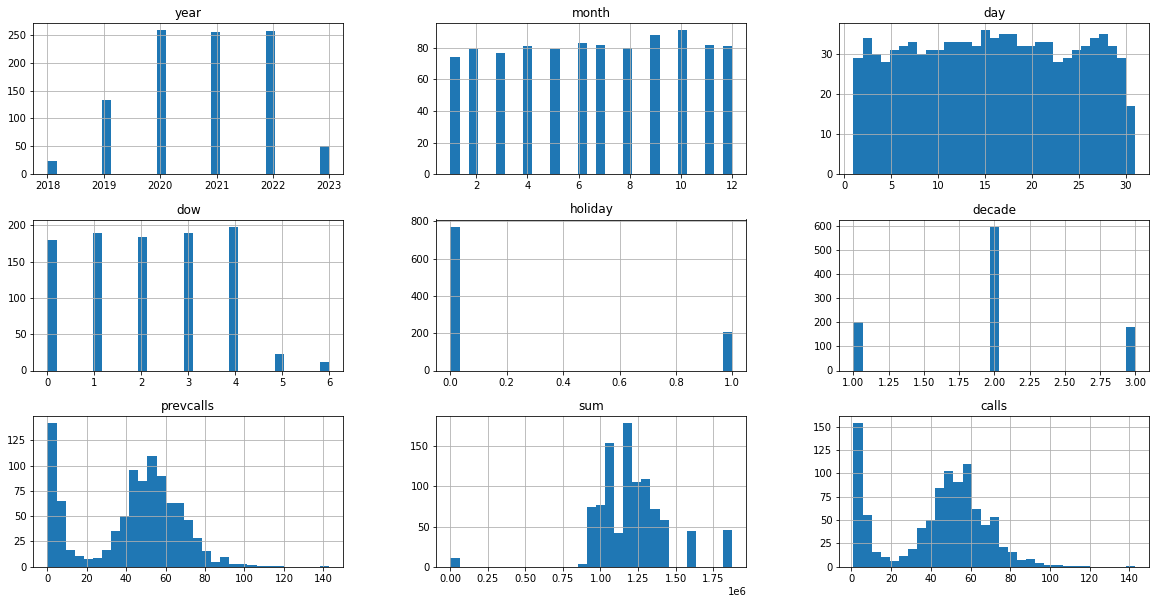

In [26]:
#смотрим гистограммы
ds.hist(figsize=(20,10), bins=31)

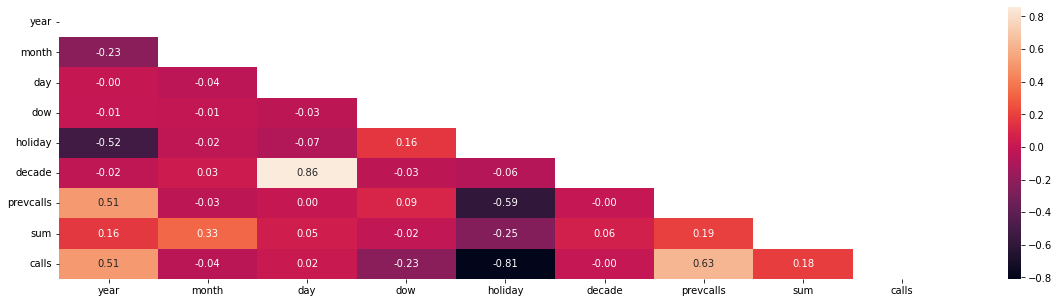

In [28]:
#смотрим корреляцию признаков между собой и с целевой переменной 
corr = ds.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,5))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f');

In [4]:
#Выделяем фичи и таргет, визуально проверим что получилось
#x = ds[['year', 'month', 'day', 'dow', 'holiday', 'decade', 'prevcalls', 'sum']]
#y = ds['calls']
x = ds.iloc[:, :8].values
y = ds.iloc[:, 8].values
print("x=", x[:10,:])
print("y=", y[:10])

x= [[   2018       6      29       4       1       3       0 1150735]
 [   2018       7       6       4       1       1       1 1105857]
 [   2018       7      11       2       1       2       4 1105857]
 [   2018       7      12       3       1       2       3 1105857]
 [   2018       9      17       0       0       2       2  919501]
 [   2018       9      18       1       1       2      21  919501]
 [   2018       9      19       2       0       2       2  919501]
 [   2018       9      20       3       1       2      33  919501]
 [   2018       9      25       1       1       2       2  919501]
 [   2018       9      27       3       1       3       9  919501]]
y= [ 1  4  3  2 21  2 33  2  9  9]


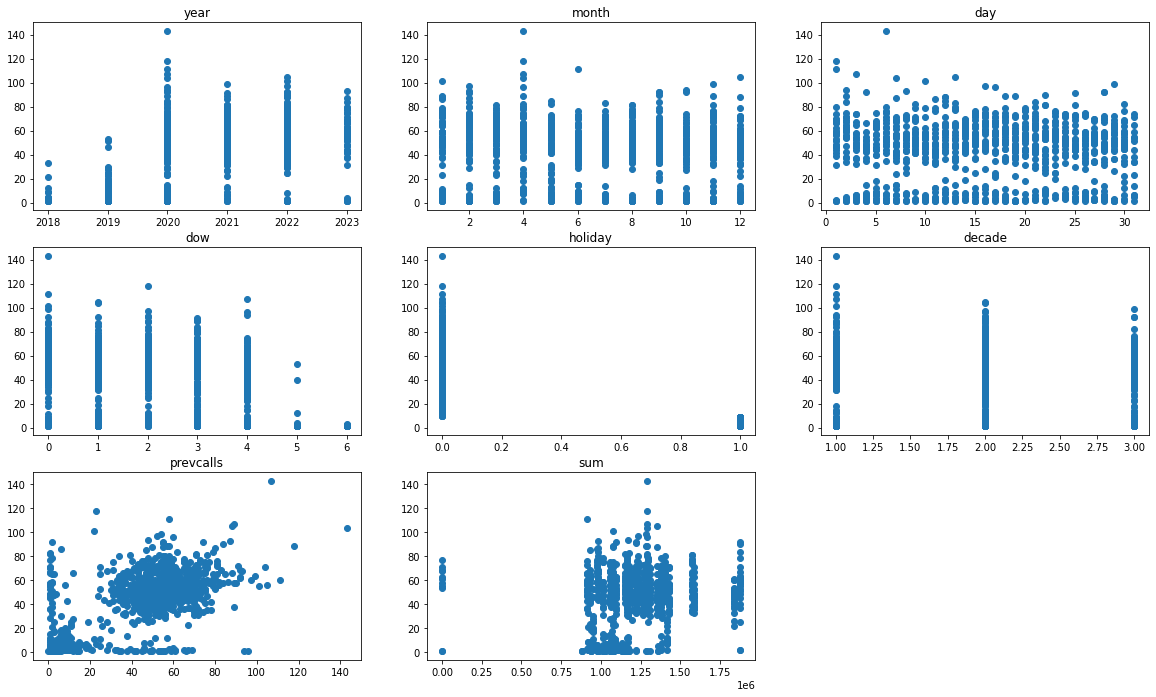

In [5]:
#визуализируем зависимости таргета от каждой фичи
feature_name=('year', 'month', 'day', 'dow', 'holiday', 'decade', 'prevcalls', 'sum')
plt.figure(figsize=(20, 20))
for i in range(len(feature_name)):
    plt.subplot(5, 3, i+1)
    plt.scatter(x[:,i], y)
    plt.title(feature_name[i])

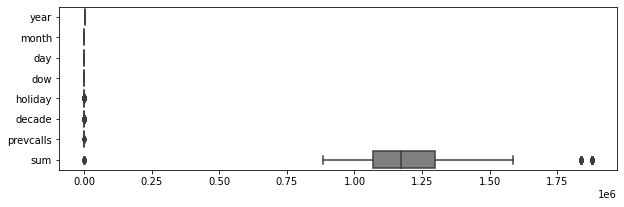

In [6]:
#проверяем нормализацию - видим сильный перекос в Sum - надо масштабировать
plt.figure(figsize=(10,3))
sns.boxplot(data=ds.iloc[:, :8], orient='h');

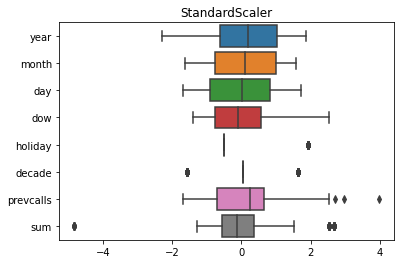

In [7]:
#масштабируем StandartScaler-ом по совету Марии
#проверяем еще раз на отмасштабированных данных - уже красивее
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ds.iloc[:, :8])
data_scaled = pd.DataFrame(X_scaled, columns=ds.columns[:8])
sns.boxplot(data=data_scaled, orient='h').set_title("StandardScaler")
ds_x = data_scaled 

In [8]:
#бьем на трейн-тест 80/20 с проверкой размеров
x_train, x_test, y_train, y_test = train_test_split(ds_x, y, test_size=0.2, random_state=13)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(781, 8) (196, 8) (781,) (196,)


##3. Применение различных алгоритмов машинного обучения - KNN, Ridge, CatBoost, LightGBM, RandomForest. Оценка результатов "из коробки".

In [9]:
#Строим модели
res = [] # собираем в массив результаты в виде [Модель, Score, MSE, MAE] для сравнения
#KNN
knn = KNeighborsRegressor(n_neighbors=5).fit(x_train, y_train) #возьмем 5 соседей
pred = knn.predict(x_test) # делаем предсказание для тестовых данных
res.append(['KNN  ',round(knn.score(x_test, y_test),3),round(np.sqrt(mean_squared_error(y_test, pred)),3),round(mean_absolute_error(y_test, pred),3)]) #фиксим результаты в массив

#Ridge с L2-регуляризацией
lrg = Ridge(alpha=0, random_state=0).fit(x_train, y_train) #возьмем alpha=0 - простая линейная регрессия
pred = lrg.predict(x_test) 
res.append(['Ridge',round(lrg.score(x_test, y_test),3),round(np.sqrt(mean_squared_error(y_test, pred)),3),round(mean_absolute_error(y_test, pred),3)])

#LightGBM
lgb = LGBMRegressor(random_state=0).fit(x_train, y_train)
pred = lgb.predict(x_test)
res.append(['LGB  ',round(lgb.score(x_test, y_test),3),round(np.sqrt(mean_squared_error(y_test, pred)),3),round(mean_absolute_error(y_test, pred),3)])

#CatBoost
cbr = CatBoostRegressor(random_state=0, logging_level='Silent').fit(x_train, y_train)
pred = cbr.predict(x_test)
res.append(['CBR  ',round(cbr.score(x_test, y_test),3),round(np.sqrt(mean_squared_error(y_test, pred)),3),round(mean_absolute_error(y_test, pred),3)])

#RandomForest
rfr = RandomForestRegressor(n_estimators = 500, random_state=0, n_jobs = -1).fit(x_train, y_train)
pred = rfr.predict(x_test)
res.append(['RFR  ',round(rfr.score(x_test, y_test),3),round(np.sqrt(mean_squared_error(y_test, pred)),3),round(mean_absolute_error(y_test, pred),3)])

print('Метод Score MSE    MAE')
for el in res:
  print(*el) #смотрим что получилось в массиве

Метод Score MSE    MAE
KNN   0.679 14.379 10.136
Ridge 0.692 14.092 10.238
LGB   0.725 13.304 9.559
CBR   0.712 13.625 9.893
RFR   0.728 13.242 9.346


##4. Тюнинг гиперпараметров, оценка результатов, выбор наилучшего алгоритма.

In [12]:
# Не стал изобретать велосипед, взял заготовку из материалов курса и допилил напильником
# KNN parameters
knn_reg_params = {
    'n_neighbors': hp.choice('n_neighbors', range(1,50)),
    'weights': hp.choice('weights',['uniform','distance']),
    'algorithm': hp.choice('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
    'p': hp.quniform('p',1,15,1)
}
knn_fit_params = {
}
knn_para = dict()
knn_para['reg_params'] = knn_reg_params
knn_para['fit_params'] = knn_fit_params
knn_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))
knn_para['loss_func_abs' ] = lambda y, pred: mean_absolute_error(y, pred)

# LRG parameters
lrg_reg_params = {
    'alpha': hp.choice('alpha',np.arange(0, 10, 0.1)),
    'fit_intercept': hp.choice('fit_intercept', [True, False]),
    'solver': hp.choice('solver', ["svd", "cholesky", "lsqr", "sag", "saga"])
}
lrg_fit_params = {
}
lrg_para = dict()
lrg_para['reg_params'] = lrg_reg_params
lrg_para['fit_params'] = lrg_fit_params
lrg_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))
lrg_para['loss_func_abs' ] = lambda y, pred: mean_absolute_error(y, pred)

# LGB parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))
lgb_para['loss_func_abs' ] = lambda y, pred: mean_absolute_error(y, pred)

# CatBoost parameters
cbr_reg_params = {
    'logging_level' : 'Silent',
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.21, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 10, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      50,
    'eval_metric':       'RMSE',
}
cbr_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
cbr_para = dict()
cbr_para['reg_params'] = cbr_reg_params
cbr_para['fit_params'] = cbr_fit_params
cbr_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))
cbr_para['loss_func_abs' ] = lambda y, pred: mean_absolute_error(y, pred)

# RandomForest parameters
rfr_reg_params = {
    #'max_features': hp.choice('max_features',['auto', 'sqrt', 'log2']),
    'n_estimators': hp.choice('n_estimators',range(1,100)),
    'max_features': hp.choice('max_features',['log2']),
    'max_depth' :  hp.choice('max_depth',[x for x in range(1,10)])
}
rfr_fit_params = {
}
rfr_para = dict()
rfr_para['reg_params'] = rfr_reg_params
rfr_para['fit_params'] = rfr_fit_params
rfr_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))
rfr_para['loss_func_abs' ] = lambda y, pred: mean_absolute_error(y, pred)

class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test, regim):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test
        self.regim = regim
        
    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result #, trials
    
    def knn_reg(self, para):
        reg = KNeighborsRegressor(**para['reg_params'])
        return self.train_reg(reg, para)
    def lrg_reg(self, para):
        reg = Ridge(**para['reg_params'])
        return self.train_reg(reg, para)
    def lgb_reg(self, para):
        reg = LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)
    def cbr_reg(self, para):
        reg = CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)
    def rfr_reg(self, para):
        reg = RandomForestRegressor(**para['reg_params'])
        return self.train_reg(reg, para)
    def train_reg(self, reg, para):
        if 'KN' in str(reg) or 'Ridge' or 'Forest' in str(reg):
            reg.fit(self.x_train, self.y_train)  
        else:
            reg.fit(self.x_train, self.y_train, eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)], **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        lossabs = para['loss_func_abs'](self.y_test, pred)
        score = reg.score(self.x_test, self.y_test)
        if self.regim == 'loss':
          return {'loss': loss, 'status': STATUS_OK} #замеряем MSE
        elif self.regim == 'lossabs':
          return {'loss': lossabs, 'status': STATUS_OK} #замеряем MAE
        else:
          return {'loss': -score, 'status': STATUS_OK} #замеряем SCORE

In [29]:
# Запускаем оптимизацию гиперпараметров, смотрим результаты
obj1 = HPOpt(x_train, x_test, y_train, y_test, 'score')
print('SCORE')
knn_opt1 = obj1.process(fn_name='knn_reg', space=knn_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
lrg_opt1 = obj1.process(fn_name='lrg_reg', space=lrg_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
cbr_opt1 = obj1.process(fn_name='cbr_reg', space=cbr_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
lgb_opt1 = obj1.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
rfr_opt1 = obj1.process(fn_name='rfr_reg', space=rfr_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
print('Лучший результат у RFR, до тюнинга было 0.728, стало около 0.75')
print('Оптимальные параметры RFR:', rfr_opt1)
obj = HPOpt(x_train, x_test, y_train, y_test, 'loss')
print('\nMSE')
knn_opt = obj.process(fn_name='knn_reg', space=knn_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
lrg_opt = obj.process(fn_name='lrg_reg', space=lrg_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
cbr_opt = obj.process(fn_name='cbr_reg', space=cbr_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
rfr_opt = obj.process(fn_name='rfr_reg', space=rfr_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
print('Лучший результат также у RFR, до тюнинга было 13.24, стало около 12.60')
print('Оптимальные параметры RFR:', rfr_opt)
obj2 = HPOpt(x_train, x_test, y_train, y_test, 'lossabs')
print('\nMAE')
knn_opt2 = obj2.process(fn_name='knn_reg', space=knn_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
lrg_opt2 = obj2.process(fn_name='lrg_reg', space=lrg_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
cbr_opt2 = obj2.process(fn_name='cbr_reg', space=cbr_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
lgb_opt2 = obj2.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
rfr_opt2 = obj2.process(fn_name='rfr_reg', space=rfr_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
print('Лучший результат также у RFR, до тюнинга было 9.3, стало около 8.9')
print('Оптимальные параметры RFR:', rfr_opt)

SCORE
100%|██████████| 50/50 [00:05<00:00,  9.72trial/s, best loss: -0.7517368631259709]
Лучший результат у RFR, до тюнинга было 0.728, стало около 0.75
Оптимальные параметры RFR: {'max_depth': 8, 'max_features': 0, 'n_estimators': 67}

MSE
100%|██████████| 50/50 [00:04<00:00, 11.03trial/s, best loss: 12.36998563682515]
Лучший результат также у RFR, до тюнинга было 13.24, стало около 12.60
Оптимальные параметры RFR: {'max_depth': 8, 'max_features': 0, 'n_estimators': 6}

MAE
100%|██████████| 50/50 [00:04<00:00, 10.78trial/s, best loss: 9.062228591022993]
Лучший результат также у RFR, до тюнинга было 9.3, стало около 8.9
Оптимальные параметры RFR: {'max_depth': 8, 'max_features': 0, 'n_estimators': 6}


##5. Попытки предсказать с помощью наилучшего алгоритма различные варианты "из будущего", не представленные в существующей выборке, эмпирическая оценка результатов (попробовать разные года, месяцы, дни месяца, дни недели, рабочие и выходные, с разным прогнозным значением абонентской платы) + проверка на реальных данных, не входящих в первоначальную выборку.

In [30]:
# по итогам экспериментов выбрали оптимальный алгоритм с гиперпараметрами RandomForest (хотя и LGB с CatBoost ненамного отстали)
params = {
    'max_depth': 8,
    'max_features': 'log2',
    'n_estimators': 90
}
reg = RandomForestRegressor(**params, random_state=13)
reg.fit(x_test, y_test)
# Накидываем разные варианты входных данных в виде ['year', 'month', 'day', 'dow', 'holiday', 'decade', 'prevcalls', 'sum']
x_future = [
[2023,7,3, datetime.date(2023, 7, 3).weekday(),   0, 1, 50, 1200000], #03-07-23 июль (мертвый сезон), понедельник, рабочий день, начало месяца, сумма абонентки средняя
[2023,7,28, datetime.date(2023, 7, 28).weekday(), 0, 3, 50, 1200000], #28-07-23 меняем дату на пятницу и конец месяца
[2023,7,28, datetime.date(2023, 7, 28).weekday(), 0, 3, 99, 1200000], #28-07-23 удваиваем предыдущие звонки
[2023,7,28, datetime.date(2023, 7, 28).weekday(), 0, 3, 99, 2400000], #28-07-23 удваиваем сумму абонентки
[2023,11,1, datetime.date(2023, 11, 1).weekday(), 0, 1, 99, 2400000], #01-11-23 меняем месяц на ноябрь (горячий сезон), среда, начало месяца
[2025,11,3, datetime.date(2025, 11, 3).weekday(), 0, 1, 99, 2400000], #03-11-25 меняем дату на 2025 год, понедельник, начало месяца
[2025,11,4, datetime.date(2025, 11, 4).weekday(), 1, 1, 99, 2400000], #04-11-25 меняем дату на вторник и праздничный нерабочий день
]
# Нормализуем наши данные выбранным и уже обученным на тестовых данных скалером
x_scaled = scaler.transform(x_future)
#эмпирически оцениваем результаты (должны сильно влиять месяц, сумма , рабочий/нерабочий день, начало/конец месяца и не сильно день месяца, день недели, год, предыдущие звонки)
print(int(reg.predict([x_scaled[0]])),' - 03-07-23 июль (мертвый сезон), понедельник, рабочий день, начало месяца, сумма абонентки средняя')
print(int(reg.predict([x_scaled[1]])),' - 28-07-23 меняем дату на пятницу и конец месяца')
print(int(reg.predict([x_scaled[2]])),' - 28-07-23 удваиваем предыдущие звонки')
print(int(reg.predict([x_scaled[3]])),' - 28-07-23 удваиваем сумму абонентки')
print(int(reg.predict([x_scaled[4]])),' - 01-11-23 меняем месяц на ноябрь (горячий сезон), среда, начало месяца')
print(int(reg.predict([x_scaled[5]])),' - 03-11-25 меняем дату на 2025 год, понедельник, начало месяца')
print(int(reg.predict([x_scaled[6]])),' - 04-11-25 меняем дату на вторник и праздничный нерабочий день') 

54  - 03-07-23 июль (мертвый сезон), понедельник, рабочий день, начало месяца, сумма абонентки средняя
51  - 28-07-23 меняем дату на пятницу и конец месяца
60  - 28-07-23 удваиваем предыдущие звонки
71  - 28-07-23 удваиваем сумму абонентки
74  - 01-11-23 меняем месяц на ноябрь (горячий сезон), среда, начало месяца
76  - 03-11-25 меняем дату на 2025 год, понедельник, начало месяца
28  - 04-11-25 меняем дату на вторник и праздничный нерабочий день


Попробуем сверить с реальными данными за март, в выборке данные только по 14 марта 2023
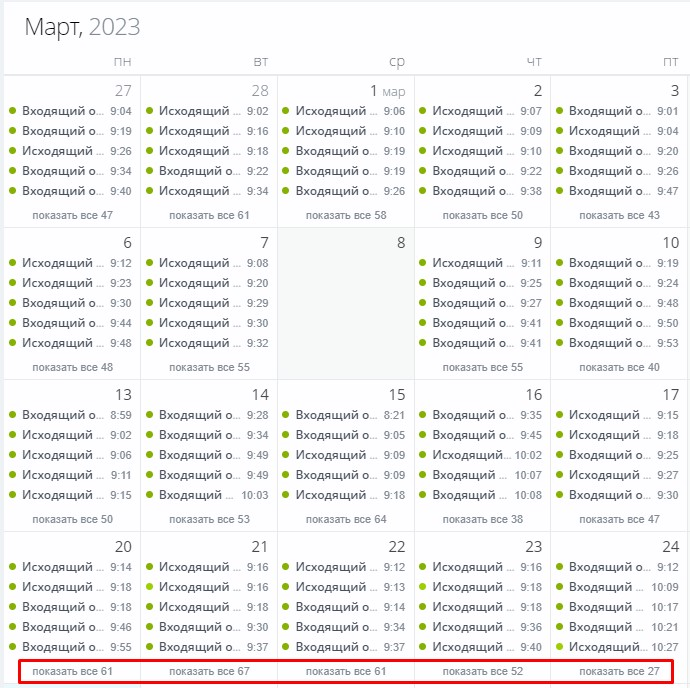

In [31]:
# Предскажем звонки за последнюю неделю
x_future1 = [
[2023,3,20, datetime.date(2023, 3, 20).weekday(), 0, 2, 47, 1200000], #20.03.23
[2023,3,21, datetime.date(2023, 3, 21).weekday(), 0, 2, 61, 1200000], #21.03.23
[2023,3,22, datetime.date(2023, 3, 22).weekday(), 0, 2, 67, 1200000], #22.03.23
[2023,3,23, datetime.date(2023, 3, 23).weekday(), 0, 2, 61, 1200000], #23.03.23
[2023,3,24, datetime.date(2023, 3, 24).weekday(), 0, 2, 52, 1200000]  #24.03.23
]
# Нормализуем наши данные выбранным и уже обученным на тестовых данных скалером
x_scaled1 = scaler.transform(x_future1)
# Сравним результаты с реальными
print(int(reg.predict([x_scaled1[0]])),' - 20.03.23, реально 61 - данные примерно совпадают (в пределах МАЕ)')
print(int(reg.predict([x_scaled1[1]])),' - 21.03.23, реально 67 - данные не совсем совпадают')
print(int(reg.predict([x_scaled1[2]])),' - 22.03.23, реально 61 - данные не совсем совпадают')
print(int(reg.predict([x_scaled1[3]])),' - 23.03.23, реально 52 - данные практически совпадают')
print(int(reg.predict([x_scaled1[4]])),' - 24.03.23, реально 27 - данные разбежались, это выброс - обычно такого по пятницам не бывает')

56  - 20.03.23, реально 61 - данные примерно совпадают (в пределах МАЕ)
54  - 21.03.23, реально 67 - данные не совсем совпадают
53  - 22.03.23, реально 61 - данные не совсем совпадают
53  - 23.03.23, реально 52 - данные практически совпадают
53  - 24.03.23, реально 27 - данные разбежались, это выброс - обычно такого по пятницам не бывает


##6. Выводы из дипломной работы и всего курса

1. В процессе работы над проектом удалось применить на практике многое из материалов курса ML.Professional:
- написан достаточно сложный парсер данных через API Битрикс24 на Python с сохранением и загрузкой результатов в файл
- выполнена серьезная предобработка данных и EDA с использованием библиотек Numpy и Pandas
- выполнено несколько визуализаций результатов с использованием Seaborn и Matplotlib, построены гистограммы и таблица корреляций
- применено масштабирование признаков
- применены различные модели предсказаний - KNN, ридж-регрессия, CatBoost, LightGBM, RandomForest
- выполнен тюнинг гиперпараметров
- изучены различные методы оценки результатов работы моделей
- выполнено предсказание реальных будущих данных - вполне вероятно, на их основе будут приниматься кадровые и управленческие решения с пользой для бизнеса

На основании этого считаю, что бизнес-цель дипломной работы достигнута на 100%.
2. Материалы курса существенно расширили мои знания в области классического ML, получены уверенные навыки в следующих областях:
- ансамбли моделей
- деревья решений
- градиентный бустинг
- методы уменьшения размерности
- обучение без учителя
- поиск аномалий в данных
- работа с текстовыми данными
- работа с временными рядами
- рекомендательные системы
- получена обширная практика работы с Google Colab и Jupiter Notebook
- и многое другое
3. Сам курс оказался на удивление интересен и полезен, хотя и достаточно сложен в изучении, так как в данный момент я не являюсь практикующим ML-инженером.  Рассматриваю его как очередную ступеньку к смене сферы деятельности и будущему трудоустройству в области Data Science.
4. Вижу для себя следующие зоны развития - расширять свои знания в области классического Machine Learning и Deep Learning, а также в сопутствующих областях - парсинге данных, работе в Python с использованием различных библиотек, также необходимо повышать знание английского языка до уровня С1, так как большинство материалов по ML и DL англоязычные.